# Selection of genes with close neighbours in individual strains
For each strain and merged vector of measurments termed 'all' genes that have high similarity to their closest 5 neighbours (actually 6 as one is itself) were selected. The gene sets obtained in each of these groups were compared with hierarchical clustering on Jaccard index transformed to distances or hypergeometric test p value  based distances. The jaccard index summarizes the degree of similarity between two sets. The hypergeometric test can be used to compute the probability of obtaining such an overlap or a better one. \
The data used was RPKUM mt removed polyA data.
The data for each strain was obtained by merging replicates into a single strain feature vector, except where noted elsehow.

In [1]:
import os
import sys
from importlib import reload

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.insert(0,module_path)

import pandas as pd
import matplotlib.pyplot as plt
import altair as alt
from statistics import median, mean
from scipy.cluster.hierarchy import dendrogram
import pickle as pkl
import glob
import seaborn as sb
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict

from Orange.clustering.louvain import jaccard

import library_regulons
reload(library_regulons)
from library_regulons import *
import jupyter_functions as jf
reload(jf)
import jupyter_functions as jf
from functionsDENet import loadPickle, savePickle


In [2]:
dataPath = '/home/karin/Documents/timeTrajectories/data/RPKUM/combined/'
dataPathSaved = '/home/karin/Documents/timeTrajectories/data/regulons/'
pathSelGenes = dataPathSaved + 'selected_genes/'

In [3]:
genes_all = pd.read_csv(dataPath + 'mergedGenes_RPKUM.tsv', sep='\t', index_col=0)
conditions_all = pd.read_csv(dataPath + 'conditions_mergedGenes.tsv', sep='\t', index_col=None)

In [41]:
SCALE = 'mean0std1'
LOG = True
NEIGHBOURS = 6
SPLITBY = 'Strain'
NGENES=NeighbourCalculator(genes_all)._genes.shape[0]
GROUP_COLOURS={
    'amiB':'#295287','mybB':'#295287','acaA':'#295287','gtaC':'#295287',
    'gbfA':'#4b9a9c','tgrC1':'#4b9a9c','tgrB1':'#4b9a9c','tgrB1C1':'#4b9a9c',
    'tagB':'#51914a','comH':'#51914a',
    'ecmARm':'#939c48','gtaI':'#939c48','cudA':'#939c48','dgcA':'#939c48','gtaG':'#939c48',
    'AX4':'#ad7836','MybBGFP':'#ad7836',
    'acaAPkaCoe':'#ad3a36','ac3PkaCoe':'#ad3a36',
    'pkaR':'#ad4994','PkaCoe':'#ad4994',
    'all':'#919091'
}

In [30]:
conditions_all['Strain'].unique()

array(['cudA', 'ac3PkaCoe', 'gtaC', 'AX4', 'tagB', 'acaAPkaCoe', 'ecmARm',
       'pkaR', 'amiB', 'gtaI', 'gbfA', 'tgrC1', 'PkaCoe', 'acaA',
       'MybBGFP', 'comH', 'mybB', 'tgrB1C1', 'tgrB1', 'dgcA', 'gtaG'],
      dtype=object)

In [35]:
def calculate_similarities(genes,conditions,n_neighbours, scale,use_log,splitby,calculate_all:bool=True,
                           remove_self:bool=False):
    """
    Calculate gene similarities for individual measurment groups
    :param genes: genes DF, genes in rows, conditions in columns
    :param conditions: Conditions DF, Measurment column ordered as genes column names
    :param splitby: Which columns of conditions Df use for splitting
    :param n_neighbours:How many neighbours to calculate
    :param scale: How to scale data for neighbour calculation
    :param use_log: log transform data before scaling
    :param calculate_all: Calculate similarities for unsplit vector, in result named as 'all'
    :param remove_self: From similarities matrix remove similarities to self, if self absent remove last similarity
    :return: Dict with keys group names and values similarity matrices, index named with genes row names 
    """
    sims_dict = dict()
    if calculate_all:
        print('all')
        neighbour_calculator_all = NeighbourCalculator(genes=genes)
        neigh_all, sims_all = neighbour_calculator_all.neighbours(n_neighbours=n_neighbours, inverse=False, 
                                                                  scale=scale, log=use_log,
                                                                  return_neigh_dist=True,remove_self=remove_self)
        sims_dict['all'] = sims_all

    # On replicates
    # Split data by replicate, scaling and zero filtering is done in neighbours
    merged = ClusterAnalyser.merge_genes_conditions(genes=genes, conditions=conditions[['Measurment', splitby]],
                                                    matching='Measurment')
    splitted = ClusterAnalyser.split_data(data=merged, split_by=splitby)
    for rep, data in splitted.items():
        splitted[rep] = data.drop([SPLITBY, 'Measurment'], axis=1).T

    # Claulculate neighbours - sims_dict has similarity matrices from samples
    for rep, data in splitted.items():
        print(rep)
        neighbour_calculator = NeighbourCalculator(genes=data)
        neigh, sims_dict[rep] = neighbour_calculator.neighbours(n_neighbours=n_neighbours, inverse=False, 
                                                                scale=scale,
                                                                log=use_log,
                                                                return_neigh_dist=True,remove_self=remove_self)
    return sims_dict

def retained_genes(sims_dict,nhubs,splitby='Strain',all_genes=NGENES,jaccard_or_p=True):
    """
    Find nhubs genes with highest average similarity to neighbours for each value in sims_dict. 
    Plot hc of similarities between retained genes
    :param sims_dict: Keys: group names, values: Similarity DFs (queries in rows, neighbour similarities in columns)
    :param nhubs: How many best genes to return, if 2 genes have same similarities ignores it (only cuts sorted df)
    :param splitby: Used in plot title
    :param jaccard_or_p: Use jaccard similarity or hypergeometric p value for distances
    :param all_genes: Used for p value calculation if jaccard_or_p=False, what to use for N in hypergeometric test
    """
    retained_genes_dict = select_genes_top(sims_dict=sims_dict,nhubs=nhubs)
    plot_genegroup_similarity(retained_genes_dict=retained_genes_dict,splitby=splitby,all_genes=all_genes,
                              jaccard_or_p=jaccard_or_p)

def select_genes_top(sims_dict,nhubs):
    """
    Find nhubs genes with highest average similarity to neighbours for each value in sims_dict. 
    :param sims_dict:Keys: group names, values: Similarity DFs (queries in rows, neighbour similarities in columns)
    :param nhubs: How many best genes to return, if 2 genes have same similarities ignores it (only cuts sorted df)
    :return: Dict with keys as sims_dict and values list of ordered selected genes, 
        genes with highest avg similarity first
    """
    retained_genes_dict = dict()
    for rep, sims in sims_dict.items():
        retained_genes_dict[rep] = NeighbourCalculator.find_hubs(similarities=sims_dict[rep], n_hubs=nhubs)
    return retained_genes_dict

def select_genes_sim(sims_dict,similarity_threshold,min_neighbours:int=1):
    """
    Find genes with min_neighbours with similarity  at least similarity_threshold. 
    :param sims_dict:Keys: group names, values: Similarity DFs (queries in rows, neighbour similarities in columns)
    :param similarity_threshold: Minimal  similarity to count a neighbour, if not dict use as threshold, 
    if dict the keys should match sims_dict keys and values should be similarity thresholds for each group
    :return: Dict with keys as sims_dict and values as list of  selected genes.
    """

    retained_genes_dict = dict()
    for rep, sims in sims_dict.items():
        if isinstance(similarity_threshold,dict):
            threshold=similarity_threshold[rep]
        else:
            threshold=similarity_threshold
        retained_genes_dict[rep] = NeighbourCalculator.filter_similarities_matrix(similarities=sims_dict[rep], 
                                                                similarity_threshold=threshold,
                                                                               min_neighbours=min_neighbours)
    return retained_genes_dict

def plot_genegroup_similarity(retained_genes_dict,splitby='Strain',all_genes=NGENES,jaccard_or_p=True):
    """
    Makes hc dendrogram of gene group similarity.
    :param retained_genes_dict: retained genes (values), group names (keys)
    :param splitby: Use in hc title, what are the groups
    :param all_genes: Used for p value calculation if jaccard_or_p=False, what to use for N in hypergeometric test
    :param jaccard_or_p: Use jaccard similarity or hypergeometric p value for distances. 
    P values are -log10 transformed and resulting similarities are converted into distances by subtraction. 
    """
    replicates = list(retained_genes_dict.keys())
    # Calculates similarities between retained genes of different samples
    retained_genes_jaccard = pd.DataFrame()
    dist_arr = []
    hypergeom_test=Hypergeometric(all_genes)
    min_p=10**-323.6
    max_sim=-np.log10(min_p)
    for idx, rep1 in enumerate(replicates[:-1]):
        for rep2 in replicates[idx + 1:]:
            genes1 = set(retained_genes_dict[rep1])
            genes2 = set(retained_genes_dict[rep2])
            if jaccard_or_p:
                jaccard_index = jaccard(genes1, genes2)
                dist_arr.append(1 - jaccard_index)
            else:
                intersection = len(genes1 & genes2)
                p =hypergeom_test.p_value(k=intersection, N=all_genes, m=len(genes1), n=len(genes2))
                if p < min_p:
                    p = min_p
                sim=-np.log10(p)
                dist_arr.append(max_sim-sim)
            
    # Plot similarity
    fig,ax=plt.subplots(figsize=(10,5))
    hc.dendrogram(hc.ward(dist_arr), labels=replicates, color_threshold=0,leaf_rotation=90)
    test=''
    if jaccard_or_p:
        test='jaccard distance'
    else:
        test='hypergeometric p value'
    plt.title('Clustered ' + splitby + 's based on '+test+' of selected genes')
    # Colour by strain  group
    xlbs=ax.get_xmajorticklabels()
    for xlb in xlbs:
        xlb.set_color(GROUP_COLOURS[xlb.get_text()])


## Comparison of selected genes in strains and all
This shows how do selected genes vary between strains and in 'all'. Gene selection: 1000 (or 200) genes with highest similarity to neighbours. The distances are based on jaccard index, as all gene sets are of the same size.

### Data: Using all replicates

In [45]:
#sims_dict5=calculate_similarities(genes=genes_all,conditions=conditions_all,n_neighbours=NEIGHBOURS, scale=SCALE,use_log=LOG,splitby=SPLITBY)
sims_dict5=loadPickle(pathSelGenes+'newGenes_noAvg_simsDict_scalemean0std1_logTrue_kN6_splitStrain.pkl')

Based on 1000 genes with highest average similarity to closest neighbour

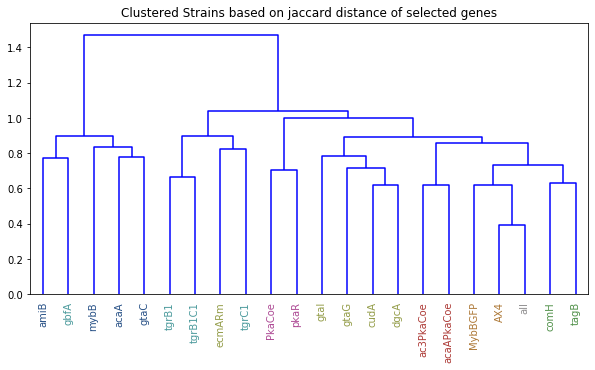

In [46]:
#retained_genes(sims_dict5,nhubs=1000,splitby='Strain')
retained_genes_dict5 = select_genes_top(sims_dict=sims_dict5,nhubs=1000)
plot_genegroup_similarity(retained_genes_dict=retained_genes_dict5,splitby='Strain',
                              jaccard_or_p=True)

The next dendrogram shows the same as the previous one. However, the distances are based on hypergeometric p values instead of jaccard index to serve as comparison for below. The resolution is not as good as quite a few p values are close to 0. 

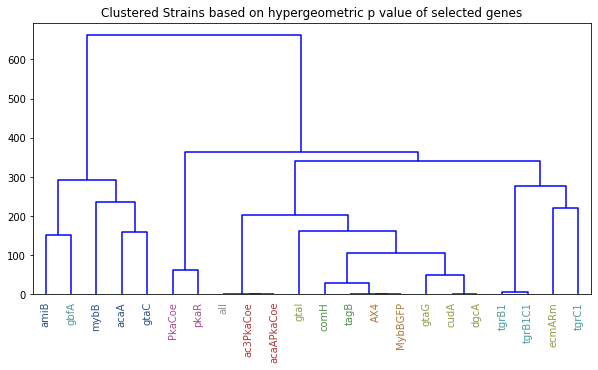

In [47]:
plot_genegroup_similarity(retained_genes_dict=retained_genes_dict5,splitby='Strain',all_genes=NGENES,
                              jaccard_or_p=False)

Clustering without 'all':

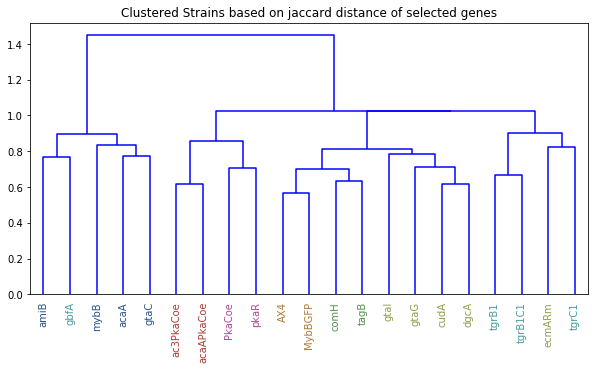

In [72]:
retained_genes_dict51=retained_genes_dict5.copy()
del retained_genes_dict51['all']
plot_genegroup_similarity(retained_genes_dict=retained_genes_dict51,splitby='Strain',
                              jaccard_or_p=True)

Based on 200 genes with highest average similarity to closest neighbour

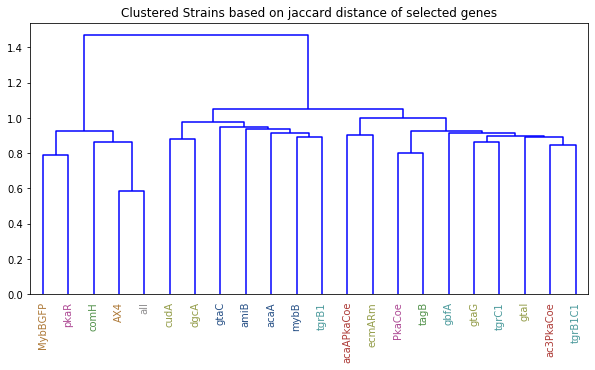

In [48]:
retained_genes(sims_dict5,nhubs=200,splitby='Strain')

The clustering of selected gene groups across strains corresponds well with phenotypes of the strains. However, the agreement between the clustering and phenotypes heavily depends on number of selected genes. Thus selection of genes must be further optimised. 

The clustering shows clear bias of genes selected on 'all' towards AX4 and thus less developmentaly stunted strains.

Thus averaging and data removal was used below to try to mitigate the bias. It was hoped that this would reduce the bias of 'all' towards AX4 due to having less measurments/features in AX4.

### Data: Averaging AX4
AX4 replicates were replaced with 3 averaged AX4 datasets: PE,SE, and FD. 

In [11]:
# ********** Average AX4 samples form new data
# Split to AX4 and rest of data
genes_conditions = ClusterAnalyser.merge_genes_conditions(genes=genes_all, conditions=conditions_all, matching='Measurment')
conditions_AX4 = conditions_all.loc[conditions_all['Strain'] == 'AX4', :]
conditions_rest = conditions_all.loc[conditions_all['Strain'] != 'AX4', :]
# Select AX4/rest genes by conditions rows so that they are both ordered the same
genes_AX4 = genes_conditions.loc[conditions_AX4['Measurment'], :]
genes_rest = genes_conditions.loc[conditions_rest['Measurment'], :]

# This is dropped in AX4 while averaging
genes_rest = genes_rest.drop(['Time', 'Strain', 'Replicate', 'Measurment'], axis=1)

# Group and average AX4, add averaged to rest
groupped_AX4 = genes_AX4.set_index('Replicate').groupby(
    {'AX4_FD_r1': 'AX4_FD', 'AX4_FD_r2': 'AX4_FD', 'AX4_PE_r3': 'AX4_PE',
     'AX4_PE_r4': 'AX4_PE', 'AX4_SE_r5': 'AX4_SE', 'AX4_SE_r6': 'AX4_SE',
     'AX4_SE_r7': 'AX4_SE'})
for name, group in groupped_AX4:
    group = group.groupby('Time').mean()
    times = list(group.index)
    group.index = [str(name) + '_' + str(idx) for idx in times]
    conditions_rest = conditions_rest.append(
        pd.DataFrame({'Measurment': group.index, 'Strain': ['AX4'] * group.shape[0],
                      'Replicate': [name] * group.shape[0], 'Time': times}), ignore_index=True, sort=True)
    genes_rest = genes_rest.append(group, sort=True)

genes_rest = genes_rest.T
# Check that ordered the same
if not (genes_rest.columns.values == conditions_rest['Measurment'].values).all():
    print('Genes and conditions are not ordered the same')

genes_avg = genes_rest
conditions_avg = conditions_rest

In [ ]:
#sims_dict=calculate_similarities(genes=genes_avg,conditions=conditions_avg,n_neighbours=NEIGHBOURS, scale=SCALE,use_log=LOG,splitby=SPLITBY)
sims_dict=loadPickle(pathSelGenes + 'newGenes_simsDict_scalemean0std1_logTrue_kN6_splitStrain.pkl')

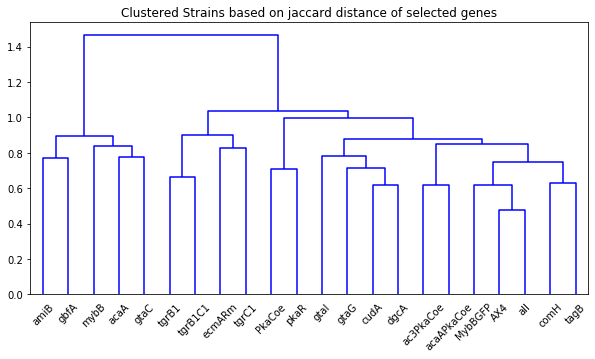

In [32]:
retained_genes(sims_dict,nhubs=1000,splitby='Strain')

### Data: no MybBGFP, AX4 only PE (2 replicates)
To further reduce the bias of 'all' towards AX4 the data of MybBGFB, which is similar to AX4, was removed and  only 2 AX4 replicates (PE) were used, further reducing number of AX4 measurments.

In [13]:
# Data without mybBGFP and only AX4_PE (non averaged)
conditions1 = conditions_all.loc[(conditions_all['Strain'] != 'MybBGFP') & (~conditions_all['Replicate'].str.contains('AX4_SE')) &
                            (~conditions_all['Replicate'].str.contains('AX4_FD')), :]
genes1 = genes_all.loc[:, conditions1['Measurment']]


In [29]:
#sims_dict1=calculate_similarities(genes=genes1,conditions=conditions1,n_neighbours=NEIGHBOURS, scale=SCALE,use_log=LOG,splitby=SPLITBY)
sims_dict1=loadPickle(pathSelGenes + 'newGenes_noMybBGFP-AX4onlyPE_simsDict_scalemean0std1_logTrue_kN6_splitStrain.pkl')

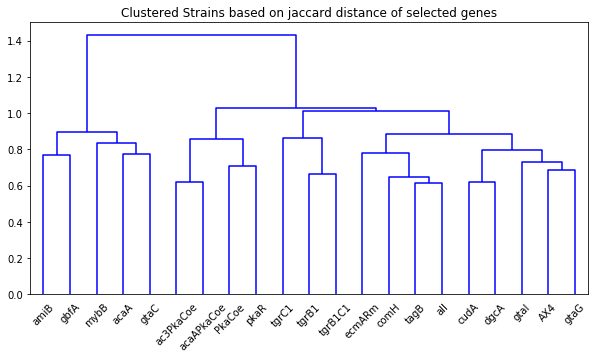

In [23]:
retained_genes(sims_dict1,nhubs=1000,splitby='Strain')

### Data: 7 measurements per replicate, no MybBGFP, AX4 only PE (2 replicates)
To further remove the bias that porobably arose due to  different number of measurments/features in individual strains only 7 measurments were used for each replicate (at time points present in most strains). Two replicates were used for each strain (for AX4 this was PE), except for gtaC wher all 20 measurments across four replicates were used. MybBGFP was not used. Even this strong correction did not completely remove the bias, possibly because there are less strains with severly stunted development, based on the dendrogram. 

In [11]:
conditions2 = conditions_all.loc[(conditions_all['Strain'] != 'MybBGFP') & (~conditions_all['Replicate'].str.contains('AX4_SE')) &
                            (~conditions_all['Replicate'].str.contains('AX4_FD')), :]
conditions_gtaC = conditions2.loc[conditions2['Strain'] == 'gtaC', :]
conditions2 = conditions2.loc[conditions2['Strain'] != 'gtaC', :]
conditions2 = conditions2.loc[conditions2['Time'].isin([0, 4, 8, 12, 16, 20, 24]), :]
conditions2 = conditions2.append(conditions_gtaC)
genes2 = genes_all.loc[:, conditions2['Measurment']]


In [28]:
#sims_dict2=calculate_similarities(genes=genes2,conditions=conditions2,n_neighbours=NEIGHBOURS, scale=SCALE,use_log=LOG,splitby=SPLITBY)
sims_dict2=loadPickle(pathSelGenes + 'newGenes_7points-noMybBGFP-AX4onlyPE_simsDict_scalemean0std1_logTrue_kN6_splitStrain.pkl')

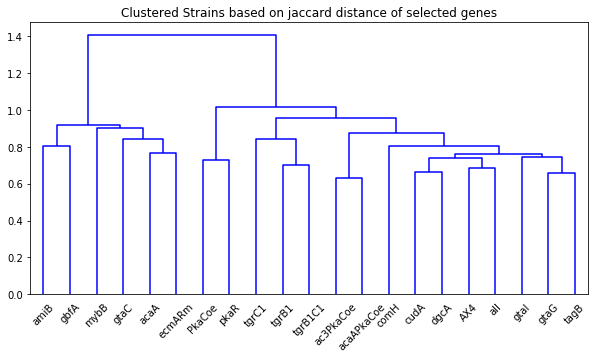

In [30]:
retained_genes(sims_dict2,nhubs=1000,splitby='Strain')

### Conclusion
Based on these results selection of genes/gene pairs based on 'all' vector may not be apropriate. To reduce the chance of having strong connections in AX4 and no similarity within developmentally stunted strains a very high similarity threshold would need to be used. This could filter out genes that have somewhat lower similarity which is nevertheless consistent across strains. 

## Selected genes based on similarity
Selection of genes based on similarity threshold (or 1000 best as above). Genes are selected if they have 5 neighbours with similarity above threshold (based on Npoints_similarity_thresholds.ipynb). Different numbers of genes are selected in individual strains and population size is not infinite (e.g. sizes of groups of selected genes are relatively close to the group of all genes). Thus jaccard index can not be selected for comparison, as it would, for example, favour similarity of large groups. Thus p value based on hypergeometric test is used.

In [111]:
NEIGHBOURS=6

In [112]:
# Calculate similarities for each strain
#sims_dict_sim=calculate_similarities(genes=genes_all,conditions=conditions_all,n_neighbours=NEIGHBOURS, 
#                                     scale=SCALE,use_log=LOG,splitby=SPLITBY,calculate_all=False,remove_self=True)

In [6]:
#savePickle(pathSelGenes + 'newGenes_noAll-removeSelf_simsDict_scalemean0std1_logTrue_kN'+str(NEIGHBOURS)+'_splitStrain.pkl',sims_dict_sim)
sims_dict_sim=loadPickle(pathSelGenes + 'newGenes_noAll-removeSelf_simsDict_scalemean0std1_logTrue_kN'+str(NEIGHBOURS)+'_splitStrain.pkl')


In [64]:
# Make a dict of similarity thresholds for each strain based on N of its dimensions
#threshold_dict={14:0.98,16:0.98,18:0.98,20:0.98,24:0.98,26:0.98,88:0.97}
#threshold_dict={14:0.95,16:0.94,18:0.94,20:0.92,24:0.92,26:0.9,88:0.87}
threshold_dict={14:0.93,16:0.91,18:0.9,20:0.9,24:0.89,26:0.86,88:0.83}
threshold_dict_strain = dict()
splitted = conditions_all.groupby(SPLITBY)
for group in splitted:
    threshold_dict_strain[group[0]]=threshold_dict[group[1].shape[0]]

In [65]:
# Filter genes based on similarity to nearest neighbour
retained_genes_dict_sim=select_genes_sim(sims_dict=sims_dict_sim,similarity_threshold=threshold_dict_strain, 
                                        min_neighbours=NEIGHBOURS-1)
#Alternatively, top N genes can be selected
#retained_genes_dict_sim=select_genes_top(sims_dict_sim,1000)

Below is hierarchical clustering of selected genes based on jaccard index distances. Some parts of tree are very unexpected (e.g. ecmARm being in ag- part). This is presumably because the number of selected genes affects the distances.

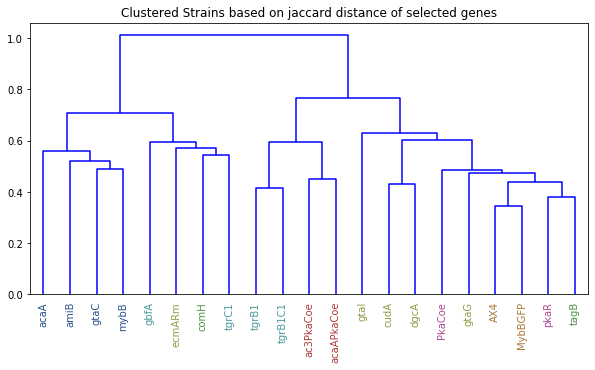

In [66]:
# Hierarchical clustering of strains based on jaccard distance between selected genes
plot_genegroup_similarity(retained_genes_dict_sim,splitby=SPLITBY,jaccard_or_p=True)

Thus, a hierarchical clustering was constructed based on hypergeometric p value. This is not affected by the sizes of groups of selected genes.The clustering is more as expected based on phenotype, indicating that selection of genes may have biological meaning.

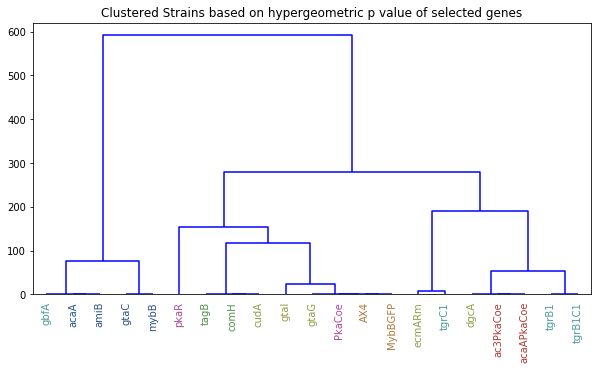

In [67]:
plot_genegroup_similarity(retained_genes_dict_sim,splitby=SPLITBY,jaccard_or_p=False)

The clustering does not correspond with the phenotypes as well as the clustering based solely on top 1000 genes with close neighbours. It might be that the similarity thresholds are not apropriate. Currently, the same thershold is used for all strains that have same number of measurments. namely, the idea was to select threshold based on N of measurments as more measurments in general lead to lower similarity. However, there are evidenti differences between strains with same N of measurements in the distirbution of similarities to the closest neighbour (Npoints_similarity_thresholds). This could be due to technical and not biological effects. Thus a threshold could be selected for each strain separately. 

In [68]:
# Make matrix of genes in  columns and strains in rows, 1 if gene selected in strain, otherwise 0
# Prepare dict for filling in gene/strain matrix
n_genes=len(genes_all.index)
n_strains=len(retained_genes_dict_sim.keys())
genes_order=dict(zip(list(genes_all.index),range(n_genes)))
strain_order=dict(zip(list(retained_genes_dict_sim.keys()),range(n_strains)))
strain_genes=np.zeros((n_strains,n_genes))

In [69]:
# Fill in gene/strain matrix
for strain, selected_genes in retained_genes_dict_sim.items():
    row=strain_order[strain]
    for gene in selected_genes:
        strain_genes[row,genes_order[gene]]=1
strain_genes=pd.DataFrame(strain_genes,index=strain_order.keys(),columns=genes_order.keys())

Below is shown the number of selected genes in each strain.

In [70]:
pd.DataFrame(strain_genes.sum(axis=1),columns=['N retained genes'])
#pd.DataFrame([len(v) for v in retained_genes_dict_sim.values()],index=list(retained_genes_dict_sim.keys()))

,N retained genes
AX4,6873.0
MybBGFP,6651.0
PkaCoe,6167.0
ac3PkaCoe,5679.0
acaA,4661.0
acaAPkaCoe,6182.0
amiB,5696.0
comH,5139.0
cudA,5485.0
dgcA,5208.0


In [104]:
strain_genes.to_csv(pathSelGenes + 'newGenes_noAll-removeSelf_selectedGenes_scalemean0std1_logTrue_kN'+str(NEIGHBOURS)+'_splitStrain.tsv',
                    sep='\t')

In [105]:
groups={'amiB':'1Ag-','mybB':'1Ag-','acaA':'1Ag-','gtaC':'1Ag-',
       'gbfA':'2LAg','tgrC1':'2LAg','tgrB1':'2LAg','tgrB1C1':'2LAg',
        'tagB':'3TA','comH':'3TA',
        'ecmARm':'4CD','gtaI':'4CD','cudA':'4CD','dgcA':'4CD','gtaG':'4CD',
        'AX4':'5WT','MybBGFP':'5WT',
        'acaAPkaCoe':'6SFB','ac3PkaCoe':'6SFB',
        'pkaR':'7PD','PkaCoe':'7PD'}

In [106]:
by_group=strain_genes.groupby(by=groups,axis=0).sum()

In [107]:
by_group_avg=strain_genes.groupby(by=groups,axis=0).mean()

In [108]:
by_group.to_csv(pathSelGenes + 'newGenes_noAll-removeSelf_selectedGenesByGroup_scalemean0std1_logTrue_kN'+str(NEIGHBOURS)+'_splitStrain.tsv',
                    sep='\t')
by_group_avg.to_csv(pathSelGenes + 'newGenes_noAll-removeSelf_selectedGenesByGroupAvg_scalemean0std1_logTrue_kN'+str(NEIGHBOURS)+'_splitStrain.tsv',
                    sep='\t')

Below are shown heatmaps of selected genes in each strain or in strain groups, showing proportion of strains where genes was selected. Selected: 1, unselected: 0, same goes for the proportions.

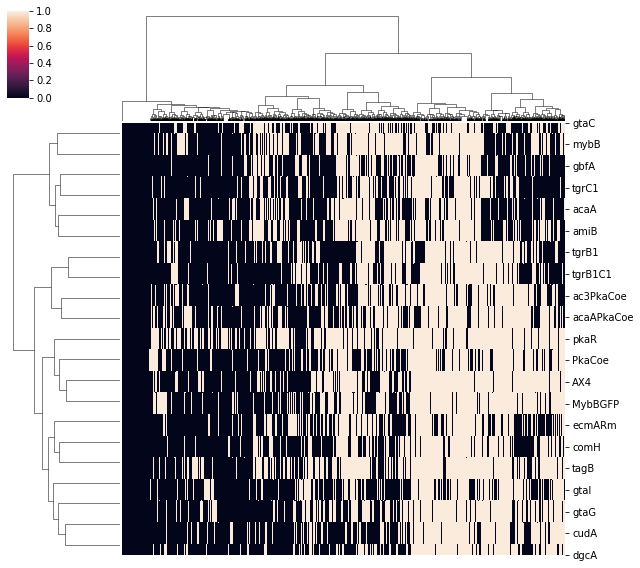

In [109]:
sb.clustermap(strain_genes,method='ward',xticklabels=False)

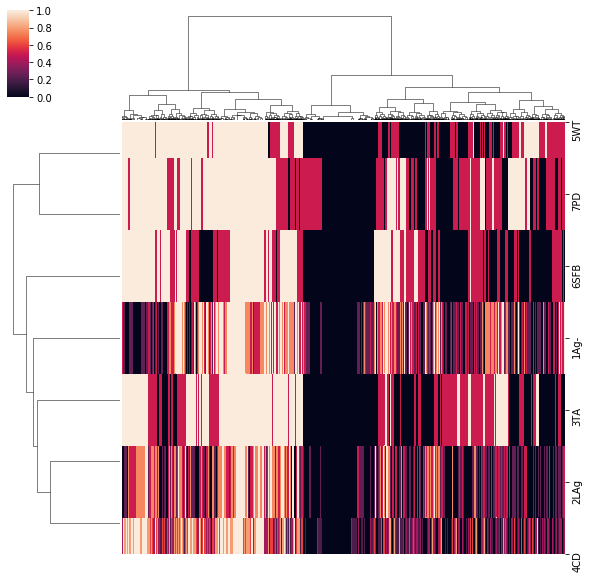

In [110]:
sb.clustermap(by_group_avg,method='ward',xticklabels=False)